# 1. Dataset

## 1.1 Loading data

In [1]:
import csv
from math import sqrt
import numpy as np
from sklearn.utils import shuffle

class UltrasonicData:
    """ A custom data type: the data member is composed with
    - the distances from the car to the surrounding wall at one or 
      multiple sample time
    - and corresponding control commands of the angular velocity.
    """
    def __init__(self, distance, angular):
        self.distance = distance
        self.angular  = angular
        
        
def csv_read(csv_path, length):
    """ Reading ultrasonic data from csv file
    
    input: 
     - csv_path: the path of the csv file
     - length: the length of time sequence used in the training samples
     - dim: the dimensions of the distance array 
    output: 
     - Return a data list which is represented in UltrasonicData 
       data type.
    """
    
    print("Reading data from %s" % csv_path)
    print("The length of time sequence in this file is %d" % length)
        
    # save time-independent sample and corresponding label with
    # UltrasonicData type
    Data = []
    
    with open(csv_path, 'r') as f:
        f_reader = csv.reader(f)
        for line in f_reader:
            # a list which saves time-dependent distance data
            dist = [float(line[j+i*18]) for i in range(length) for j in range(16)]
            # use the newest command as label
            agl  = float(line[17+(length-1)*18])
            #[float(line[17+i*18]) for i in range(length)]
            Data.append(UltrasonicData(dist, agl))
    
    print("Now {} data have been saved with custom data type".format(len(Data)))
    
    return shuffle(Data)

def data_generator(Data, batch_size, dim=2, shape=(16,16)):
    """ A python data generator
    input: 
    - Data: a list in which data is saved with custom data type
    - batch_size: the size of data batch we want to return
    - dim: the dimensions of data used for training or validation
    - shape: data repeat operation will be done according to this
             parameter.
    return：
    - yeild a batch of samples and lebel when it is called
    """
    height, width = shape
    while True:
        data_batch = np.random.choice(a=Data, size=batch_size)
        X = []
        Y = []
    
        for i in range(len(data_batch)):
            data = data_batch[i]
            if dim == 1:
                dist = data.distance
            elif dim == 2:
                dist = np.array(data.distance)
                # reshape
                dist = dist.reshape(-1,16)
                
                # repeat coloums and rows according to desired width
                dist = dist.repeat(width//16, axis=0)
                dist = dist.repeat(width//16, axis=1)
                
                # add channel axis for the gray scale image
                dist = dist[np.newaxis, :,:]
                
            else:
                pass
            
            # add batch axis
            X.append(dist)
            Y.append(data.angular)
        
        X = np.array(X)
        Y = np.array(Y)
        
        yield X, Y

## 1.2 Loading Test

In [2]:
"""
TESTING DATA LOADING FUNCTION
"""
from itertools import product

data_path  = "/media/ubuntu16/Documents/datasets/Sonar/SIM/Track-I-II/"
filename = "2019-07-03-"

batch_size = 128
dims = [1,2]
lengths = [1,16,32,48]

for dim, length in product(dims,lengths):
    csv_path = data_path + filename + str(length) + '.csv'
    dataset = csv_read(csv_path=csv_path, length=length)
    
    # load data through generator
    training_set = data_generator(dataset, 
                                  batch_size=batch_size, 
                                  dim=dim, 
                                  shape=(None,16))
    
    x,y = next(training_set)
    print x.shape, y.shape
    print 

Reading data from /media/ubuntu16/Documents/datasets/SonarSet/SIM/Track-I-II/2019-07-03-1.csv
The length of time sequence in this file is 1
Now 45422 data have been saved with custom data type
(128, 16) (128,)

Reading data from /media/ubuntu16/Documents/datasets/SonarSet/SIM/Track-I-II/2019-07-03-16.csv
The length of time sequence in this file is 16
Now 45299 data have been saved with custom data type
(128, 256) (128,)

Reading data from /media/ubuntu16/Documents/datasets/SonarSet/SIM/Track-I-II/2019-07-03-32.csv
The length of time sequence in this file is 32
Now 45198 data have been saved with custom data type
(128, 512) (128,)

Reading data from /media/ubuntu16/Documents/datasets/SonarSet/SIM/Track-I-II/2019-07-03-48.csv
The length of time sequence in this file is 48
Now 45078 data have been saved with custom data type
(128, 768) (128,)

Reading data from /media/ubuntu16/Documents/datasets/SonarSet/SIM/Track-I-II/2019-07-03-1.csv
The length of time sequence in this file is 1
Now 454

# 2. Baseline
## 2.1 Constant Baseline
In this section, we use 0 as a constant prediction to compute the mse, rmse, mae, r-square, adjusted r-square of the ultrasonic datasets.
- Reading all labels from csv file.
- compute the values of corresponding metrcis

In [3]:
def label_read(csv_path, length):    
    import csv
    import numpy as np
    
    agls = []
    with open(csv_path, 'r') as f:
        f_reader = csv.reader(f)
        for line in f_reader:
            agl  = float(line[17+(length-1)*18])
            agls.append(agl)
    
    return np.array(agls)

def mse(y_true, y_pred):
    import numpy as np
    
    return np.mean(np.square(y_true-y_pred))

def rmse(y_true, y_pred):
    import numpy as np
    
    return np.sqrt(np.mean(np.square(y_true-y_pred)))

def mae(y_true, y_pred):
    import numpy as np
    
    return np.mean(np.abs(y_true-y_pred))

def r_square(y_true, y_pred):
    import numpy as np
    sse = np.sum(np.square(y_true-y_pred))
    sst = np.sum(np.square(y_true-np.mean(y_true)))
    r2  = 1 - sse/sst
    return r2

def ad_r_square(y_true, y_pred, p):
    import numpy as np
    sse = np.sum(np.square(y_true-y_pred))
    sst = np.sum(np.square(y_true-np.mean(y_true)))
    r2  = 1 - sse/sst
    n   = y_true.shape[0]
    return 1 - (1-r2)*(n-1)/(n-1-p)

In [5]:
csv_path  = "/media/ubuntu16/Documents/datasets/Sonar/SIM/Track-I-II/2019-07-03-48.csv"

baseline_rmse, baseline_mae, baseline_r_square, baseline_ad_r_square = [], [], [], []

for length in range(1,49):
    y_true = label_read(csv_path, length)
    y_pred = 0
    p = length
    
    baseline_rmse.append(rmse(y_true, y_pred))
    baseline_mae.append(mae(y_true, y_pred))
    baseline_r_square.append(r_square(y_true, y_pred))
    baseline_ad_r_square.append(ad_r_square(y_true, y_pred, p))

In [109]:
print(" rmse: {} \n mae: {} \n r2: {} \n ar2: {} \n".format( baseline_rmse[11], 
                                                                       baseline_mae[11], baseline_r_square[11],
                                                                      baseline_ad_r_square[11]))

 rmse: 0.199195749163 
 mae: 0.0895978625698 
 r2: -0.000712289456118 
 ar2: -0.000978761163063 



In [25]:
r2=-0.000712289456118
n=45078
p=12*16

print 1 - (1-r2)*(n-1)/(n-1-p)

-0.00499293465107


In [110]:
print y_true.shape[0]
print len(baseline_rmse)

45078
48


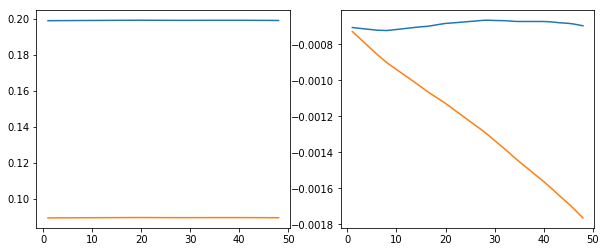

In [15]:
from matplotlib import pyplot as plt
import numpy as np

fig1, (ax11,ax12) = plt.subplots(1,2, figsize=(10,4))
x = np.arange(1,49,1)
ax11.plot(x, baseline_rmse)
ax11.plot(x, baseline_mae)

ax12.plot(x, baseline_r_square)
ax12.plot(x, baseline_ad_r_square)

plt.show()

==== FOR LENGTH 1 ====
mse: 0.0394501912088, rmse: 0.198620722002, mae: 0.0890980140852
r_square: -0.000699790050676, ad_r_square: -0.00105242074423
==== FOR LENGTH 16 ====
mse: 0.0395573099867, rmse: 0.198890195803, mae: 0.0893399411859
r_square: -0.000701691518119, ad_r_square: -0.00638926385124
==== FOR LENGTH 32 ====
mse: 0.0395987612048, rmse: 0.198994374807, mae: 0.0894136028681
r_square: -0.000670864849392, ad_r_square: -0.0121365352713
==== FOR LENGTH 48 ====
mse: 0.0396631361429, rmse: 0.199156059769, mae: 0.0895534258817
r_square: -0.000697791798569, ad_r_square: -0.0180427082738